#Library

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


In [2]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=034012448688ead6cc8c1b9768e16ed4aeb29b58d2c1949eca0c41ef809dca1b
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [3]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2023-06-11 05:11:15--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.08s   

2023-06-11 05:11:16 (308 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-06-11 05:11:17--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respon

In [4]:
pip install accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 11.3 MB/s eta 0:00:00


# Data loader and pre-processing

In [5]:
import pandas as pd
# load data
train = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/UIT-ViCTSD_train.csv", index_col=False)
dev = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/UIT-ViCTSD_valid.csv", index_col=False)
test = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/UIT-ViCTSD_test_label.csv", index_col=False)

train.reset_index(drop=True)

print(len(train))
print(len(dev))
print(len(test))

7000
2000
1000


In [6]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [7]:
#pre-process
import re
import numpy as np

STOPWORDS = 'drive/My Drive/CODE/HSD/vietnamese-stopwords.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    # text = filter_stop_words(text, stopwords)
    # text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['Comment']
y_train = train['Toxicity'].values.astype(int)

X_dev = dev['Comment']
y_dev = dev['Toxicity'].values.astype(int)

X_test = test['Comment']
y_test = test['Toxicity'].values.astype(int)

# Model


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, input, target):
        logit = F.log_softmax(input, dim=1)
        pt = torch.exp(logit)
        logit = (1 - pt)**self.gamma * logit
        loss = F.nll_loss(
            logit, target, self.weight, ignore_index=self.ignore_index)
        return loss


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = FocalLoss()
        loss = loss_fct(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss

## multilingual bert

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.092100


[[871  19]
 [ 78  32]]
F1 - micro: 0.903
F1 - macro: 0.6723847351551444


<Axes: >

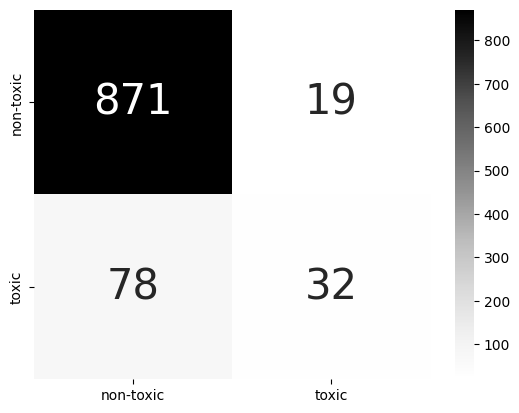

In [9]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-m-bert/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-m-bert/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## multilingual-bert-uncased

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.102300


[[890   0]
 [110   0]]
F1 - micro: 0.89
F1 - macro: 0.4708994708994709


<Axes: >

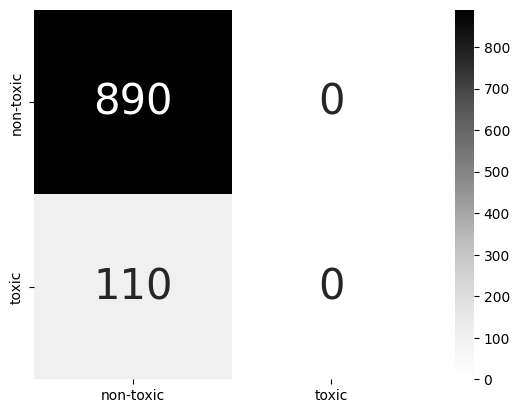

In [10]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = True)
  
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-m-bert-uncased/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-m-bert-uncased/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## xlm-r

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.100500


[[890   0]
 [110   0]]
F1 - micro: 0.89
F1 - macro: 0.4708994708994709


<Axes: >

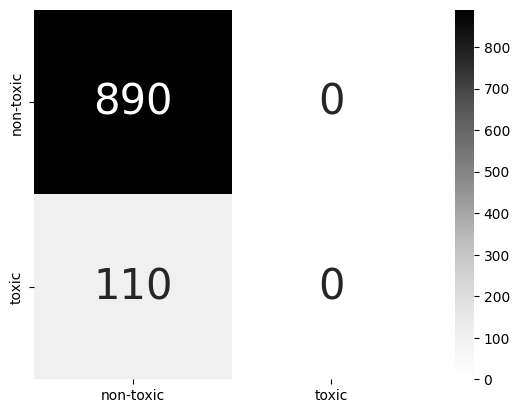

In [11]:
# PhoBERT
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-xlm-r/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-xlm-r/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## DistilBERT

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.093800


[[874  16]
 [ 85  25]]
F1 - micro: 0.899
F1 - macro: 0.6382508533340019


<Axes: >

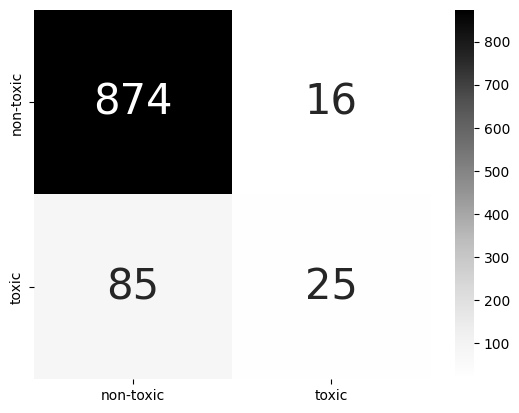

In [12]:
# PhoBERT
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-distil-bert/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-distil-bert/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## PhoBERT

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.079400


[[864  26]
 [ 60  50]]
F1 - micro: 0.914
F1 - macro: 0.7451126839041624


<Axes: >

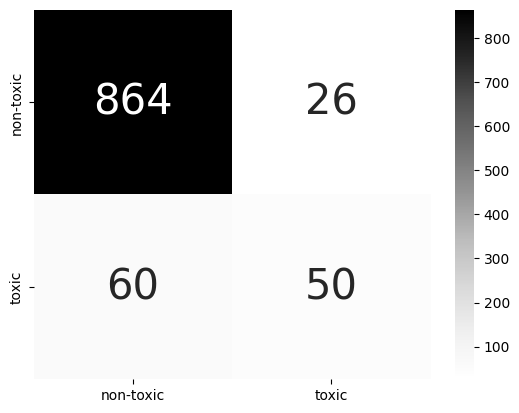

In [13]:

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-phobert/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-phobert/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## BERT4News

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NlpHUST/vibert4news-

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.080600
1000,0.051800


[[850  40]
 [ 60  50]]
F1 - micro: 0.9
F1 - macro: 0.7222222222222222


<Axes: >

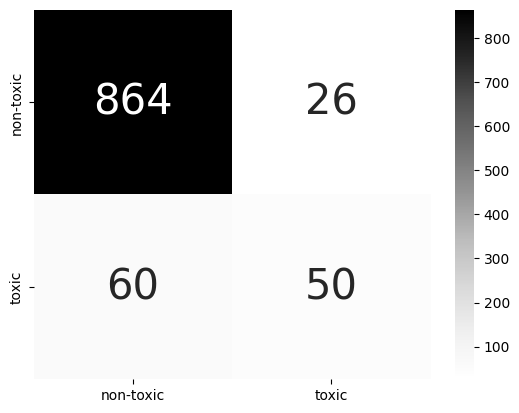

In [23]:
# Bert4news
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = BertForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = 2)
tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-bert4news/',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/MyDrive/CODE/ViSocial/transformer_model/victsd-toxic/focal-bert4news/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf2 = confusion_matrix(y_true, y_pred)
print(cf2)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## ViELECTRA

Some weights of the model checkpoint at FPTAI/velectra-base-discriminator-cased were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at FPTAI/velectra-base-discriminator-cased and are newly initialized: ['

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.096700
1000,0.079700
1500,0.048100


[[854  36]
 [ 66  44]]
F1 - micro: 0.898
F1 - macro: 0.7034021517883106


<Axes: >

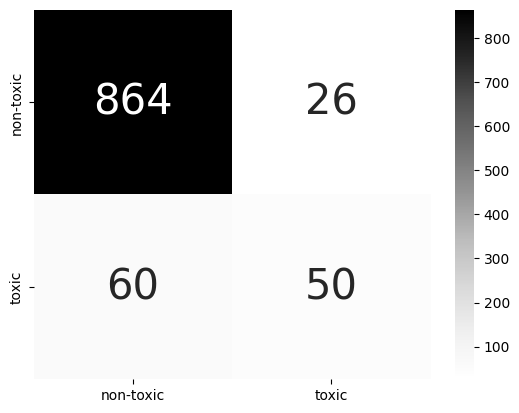

In [22]:
# ViELECTRA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("FPTAI/velectra-base-discriminator-cased", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("FPTAI/velectra-base-discriminator-cased",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='drive/My Drive/CODE/ViSocial/transformer_model/victsd-toxic/focal-vielectra/',          
    num_train_epochs=4,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("drive/My Drive/CODE/ViSocial/transformer_model/victsd-toxic/focal-vielectra/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf2 = confusion_matrix(y_true, y_pred)
print(cf2)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})